In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
from src.utils.general import LogTime
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import matplotlib.pyplot as plt
import joblib
import random
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\tacke\AppData\Local\Temp\ipykernel_12948\3185592865.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_6", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")

# Generating Synthetic Time Series

In [4]:
length = 100
index = pd.date_range(start="2021-11-03", periods=length)
# White Noise
y_random = pd.Series(np.random.randn(length), index=index)
# White Noise
y_random_2 = pd.Series(np.random.randn(length), index=index)
# White Noise+Trend
_y_random = pd.Series(np.random.randn(length), index=index)
t = np.arange(len(_y_random))
y_trend = _y_random+t*_y_random.mean()*0.8
# Heteroscedastic
_y_random = pd.Series(np.random.randn(length), index=index)
t = np.arange(len(_y_random))
y_hetero = (_y_random*t)
#WhiteNoise + Seasonal
_y_random = pd.Series(np.random.randn(length), index=index)
t = np.arange(len(_y_random))
y_seasonal = (_y_random+1.9*np.cos((2*np.pi*t)/(length/4)))
#unit root
_y_random = pd.Series(np.random.randn(length), index=index)
y_unit_root = _y_random.cumsum()

plot_df = pd.DataFrame({"Time":np.arange(100),"Timeseries 1": y_random, "Timeseries 2": y_trend, "Timeseries 3": y_hetero, "Timeseries 4": y_unit_root, "Timeseries 5": y_seasonal, "Timeseries 6": y_random_2})

In [5]:
y_trend

2021-11-03    0.357787
2021-11-04    0.612702
2021-11-05    1.186885
2021-11-06    1.209553
2021-11-07   -1.170001
                ...   
2022-02-06    4.239206
2022-02-07    5.883632
2022-02-08    5.343249
2022-02-09    5.900728
2022-02-10    5.769412
Freq: D, Length: 100, dtype: float64

In [6]:
fig = px.line(pd.melt(plot_df, id_vars="Time", value_name="Observed"), x="Time", y="Observed", facet_col="variable", facet_col_wrap=3)
fig.update_yaxes(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1], font=dict(size=16)))
fig.update_layout(
            autosize=False,
            width=1600,
            height=800,
            yaxis=dict(
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.update_annotations(font_size=20)
fig.write_image("imgs/chapter_6/stationary_ts.png")
fig.show()

# Unit Roots

## Plotting Autoregressive series with different $\phi$

In [7]:
def generate_autoregressive_series(length, phi):
    x_start = random.uniform(-1, 1)
    y = []
    for i in range(length):
        t = x_start*phi+random.uniform(-1, 1)
        y.append(t)
        x_start = t
    return np.array(y)

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

#pio.renderers.default = "notebook"
#pio.kaleido.scope.mathjax = None

fig = make_subplots(
    rows=3, cols=1, subplot_titles=("$\phi=0.8$", "$\phi=1.0$", "$\phi=1.05$")
)

fig.append_trace(
    go.Scatter(
        x=np.arange(length),
        y=generate_autoregressive_series(length, phi=0.8),
    ),
    row=1,
    col=1,
)

fig.append_trace(
    go.Scatter(
        x=np.arange(length),
        y=generate_autoregressive_series(length, phi=1.0),
    ),
    row=2,
    col=1,
)

fig.append_trace(
    go.Scatter(x=np.arange(length), y=generate_autoregressive_series(length, phi=1.05)),
    row=3,
    col=1,
)


fig.update_layout(
    height=700,
    width=700,
    showlegend=False,
    yaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
    xaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
)
fig.write_image("imgs/chapter_6/ar_series_phi.png")
fig.show()

## Detecting Unit Root

In [9]:
from src.transforms.stationary_utils import check_unit_root

res = check_unit_root(y_unit_root, confidence=0.05)

print(f"Stationary: {res.stationary} | p-value: {res.results[1]}")

Stationary: False | p-value: 0.30080859974740337


## Differencing

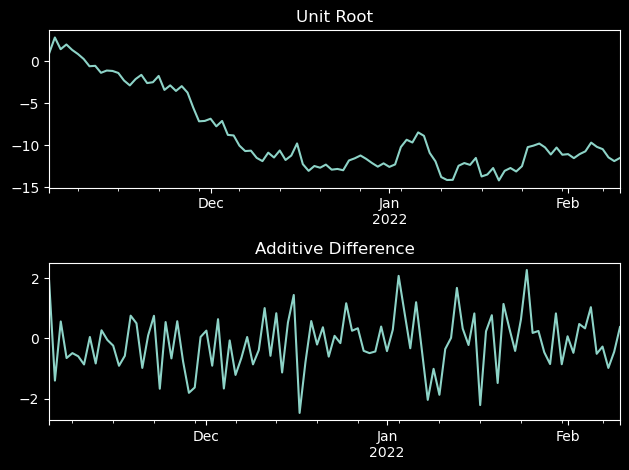

ADF_Test(stationary=True, results=(-10.811906709806534, 1.899288241517489e-19, 0, 98, {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}, 235.71797349008392))

In [10]:
from src.transforms.target_transformations import AdditiveDifferencingTransformer, MultiplicativeDifferencingTransformer

diff_transformer = AdditiveDifferencingTransformer()
# [1:] because differencing reduces the lenght of the time series by one
y_diff = diff_transformer.fit_transform(y_unit_root)[1:]
fig, axs = plt.subplots(2)
y_unit_root.plot(title="Unit Root",ax=axs[0])
y_diff.plot(title="Additive Difference",ax=axs[1])
plt.tight_layout()
plt.show()
check_unit_root(y_diff)

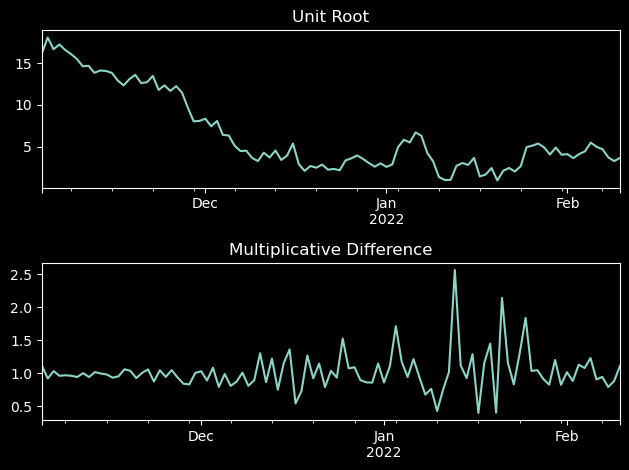

ADF_Test(stationary=True, results=(-5.8712144385484235, 3.236921869282593e-07, 3, 95, {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}, 48.71998024926833))

In [11]:
_y_unit_root = y_unit_root + np.abs(y_unit_root.min())+1
diff_transformer = MultiplicativeDifferencingTransformer()
# [1:] because differencing reduces the lenght of the time series by one
y_diff = diff_transformer.fit_transform(_y_unit_root)[1:]
fig, axs = plt.subplots(2)
_y_unit_root.plot(title="Unit Root",ax=axs[0])
y_diff.plot(title="Multiplicative Difference",ax=axs[1])
plt.tight_layout()
plt.show()
check_unit_root(y_diff)

# Trends

In [12]:
from src.transforms.stationary_utils import check_trend, check_deterministic_trend

In [13]:
y_trend

2021-11-03    0.357787
2021-11-04    0.612702
2021-11-05    1.186885
2021-11-06    1.209553
2021-11-07   -1.170001
                ...   
2022-02-06    4.239206
2022-02-07    5.883632
2022-02-08    5.343249
2022-02-09    5.900728
2022-02-10    5.769412
Freq: D, Length: 100, dtype: float64

In [14]:
ar_series = generate_autoregressive_series(length, phi=1.05)

beta_0 = 0.5
beta_1 = 0.1
x = np.arange(length)
y_trend = beta_0 + beta_1*x + np.random.rand(length)

In [15]:
x


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [16]:
y_trend

array([ 0.7292514 ,  1.32225257,  1.42003654,  1.44114763,  1.59394844,
        1.54272444,  1.35179906,  1.54569599,  1.48159772,  2.30845056,
        2.08339179,  2.00085142,  2.1620058 ,  2.74728334,  2.0533514 ,
        2.58622983,  2.60588868,  2.81145424,  2.31811018,  3.27212391,
        3.43211828,  3.16513318,  3.39665082,  3.72249938,  3.60723863,
        3.15253904,  3.67628836,  3.80671505,  3.72413067,  4.13644424,
        4.43436701,  4.52556851,  4.15083937,  3.91323805,  4.8848412 ,
        4.83889809,  4.22466268,  5.12084188,  5.16989636,  4.91883806,
        5.09127544,  4.9990027 ,  4.75476164,  5.13519724,  5.70285345,
        5.00463202,  5.43349917,  5.59816869,  5.8373956 ,  6.31985562,
        5.84634599,  5.9469532 ,  6.43750125,  6.25221794,  6.12460482,
        6.45243952,  6.24085702,  6.37638699,  6.79836777,  6.81892545,
        7.4148459 ,  6.9623939 ,  7.28058835,  7.43226429,  6.91309446,
        7.66353737,  7.27803597,  8.16107032,  7.44866273,  7.81

In [17]:
fig = make_subplots(
    rows=2, cols=1, 
    subplot_titles=(
        r'$\text{AR(1) with } \phi=1.05$', 
        r'$\text{Linear Trend with } \beta_0 = 0.5 \text{, } \beta_1 = 0.1$'
    )
)

fig.append_trace(
    go.Scatter(
        x=np.arange(length),
        y=ar_series,
    ),
    row=1,
    col=1,
)

fig.append_trace(
    go.Scatter(
        x=np.arange(length),
        y=y_trend,
    ),
    row=2,
    col=1,
)

fig.update_layout(
    height=500,
    width=700,
    showlegend=False,
    yaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
    xaxis=dict(
        titlefont=dict(size=15),
        tickfont=dict(size=15),
    ),
)
fig.write_image("imgs/chapter_6/deterministic_series_phi.png")
fig.show()

In [18]:
res = check_deterministic_trend(ar_series)
print(f"Stationary: {res.adf_res.stationary} | Deterministic Trend: {res.deterministic_trend}")

Stationary: False | Deterministic Trend: False


In [19]:
res = check_deterministic_trend(y_trend)
print(f"Stationary: {res.adf_res.stationary} | Deterministic Trend: {res.deterministic_trend}")

Stationary: False | Deterministic Trend: True


## Detecting Trend

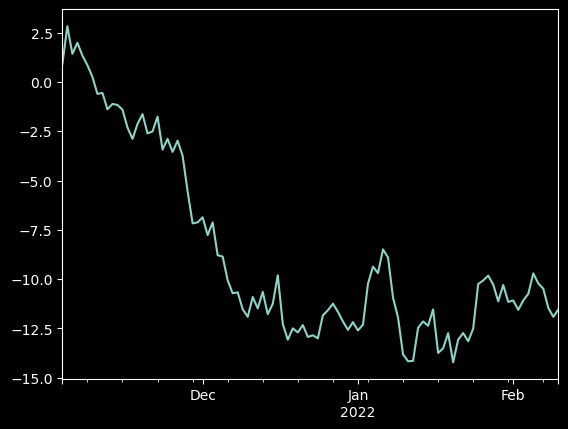

Kendalls Tau: Trend: True | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: True | Direction: decreasing | Deterministic: False


In [20]:
y_unit_root.plot()
plt.show()
kendall_tau_res = check_trend(y_unit_root, confidence=0.05)
mann_kendall_res = check_trend(y_unit_root, confidence=0.05, mann_kendall=True)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")

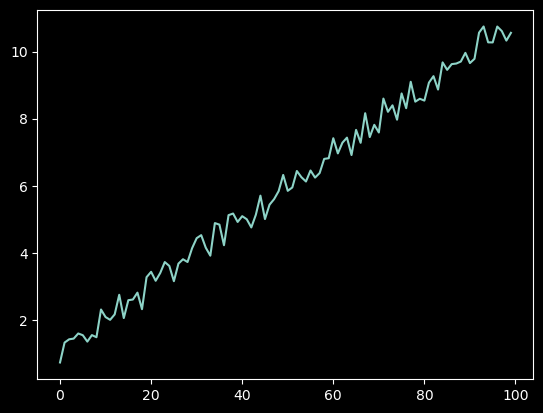

Kendalls Tau: Trend: True | Direction: increasing | Deterministic: True
Mann-Kendalls: Trend: True | Direction: increasing | Deterministic: True


In [21]:
plt.plot(y_trend)
plt.show()
kendall_tau_res = check_trend(y_trend, confidence=0.05)
mann_kendall_res = check_trend(y_trend, confidence=0.05, mann_kendall=True)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")

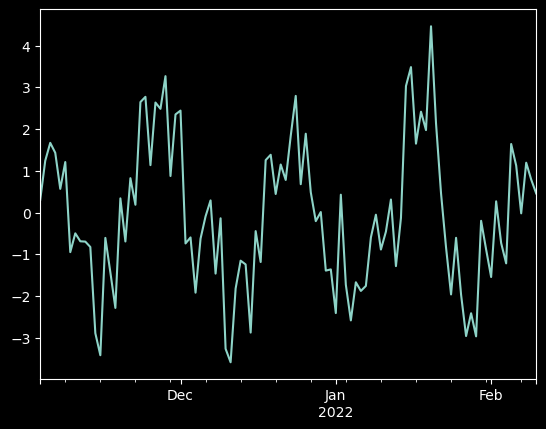

Kendalls Tau: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: False | Direction: decreasing | Deterministic: False


In [22]:
y_seasonal.plot()
plt.show()
kendall_tau_res = check_trend(y_seasonal, confidence=0.05)
mann_kendall_res = check_trend(y_seasonal, confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(y_seasonal, confidence=0.05, mann_kendall=True, seasonal_period=25)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

## DeTrending

In [23]:
y_trend

array([ 0.7292514 ,  1.32225257,  1.42003654,  1.44114763,  1.59394844,
        1.54272444,  1.35179906,  1.54569599,  1.48159772,  2.30845056,
        2.08339179,  2.00085142,  2.1620058 ,  2.74728334,  2.0533514 ,
        2.58622983,  2.60588868,  2.81145424,  2.31811018,  3.27212391,
        3.43211828,  3.16513318,  3.39665082,  3.72249938,  3.60723863,
        3.15253904,  3.67628836,  3.80671505,  3.72413067,  4.13644424,
        4.43436701,  4.52556851,  4.15083937,  3.91323805,  4.8848412 ,
        4.83889809,  4.22466268,  5.12084188,  5.16989636,  4.91883806,
        5.09127544,  4.9990027 ,  4.75476164,  5.13519724,  5.70285345,
        5.00463202,  5.43349917,  5.59816869,  5.8373956 ,  6.31985562,
        5.84634599,  5.9469532 ,  6.43750125,  6.25221794,  6.12460482,
        6.45243952,  6.24085702,  6.37638699,  6.79836777,  6.81892545,
        7.4148459 ,  6.9623939 ,  7.28058835,  7.43226429,  6.91309446,
        7.66353737,  7.27803597,  8.16107032,  7.44866273,  7.81

In [24]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [25]:
y_trend

array([ 0.7292514 ,  1.32225257,  1.42003654,  1.44114763,  1.59394844,
        1.54272444,  1.35179906,  1.54569599,  1.48159772,  2.30845056,
        2.08339179,  2.00085142,  2.1620058 ,  2.74728334,  2.0533514 ,
        2.58622983,  2.60588868,  2.81145424,  2.31811018,  3.27212391,
        3.43211828,  3.16513318,  3.39665082,  3.72249938,  3.60723863,
        3.15253904,  3.67628836,  3.80671505,  3.72413067,  4.13644424,
        4.43436701,  4.52556851,  4.15083937,  3.91323805,  4.8848412 ,
        4.83889809,  4.22466268,  5.12084188,  5.16989636,  4.91883806,
        5.09127544,  4.9990027 ,  4.75476164,  5.13519724,  5.70285345,
        5.00463202,  5.43349917,  5.59816869,  5.8373956 ,  6.31985562,
        5.84634599,  5.9469532 ,  6.43750125,  6.25221794,  6.12460482,
        6.45243952,  6.24085702,  6.37638699,  6.79836777,  6.81892545,
        7.4148459 ,  6.9623939 ,  7.28058835,  7.43226429,  6.91309446,
        7.66353737,  7.27803597,  8.16107032,  7.44866273,  7.81

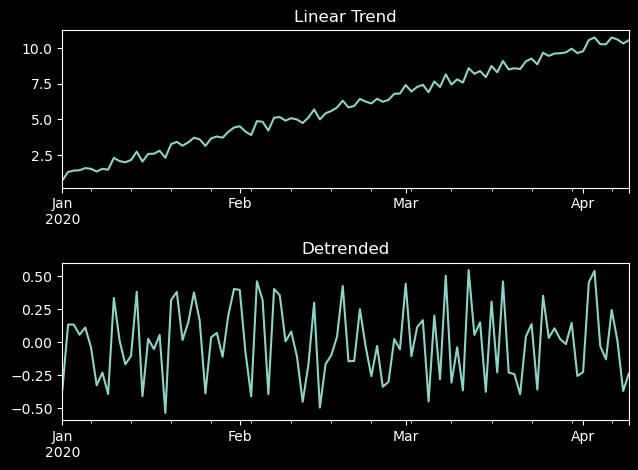

Kendalls Tau: Trend: False
Mann-Kendalls: Trend: False


In [26]:
from src.transforms.target_transformations import DetrendingTransformer

detrending_transformer = DetrendingTransformer()
dates = pd.date_range(start='20200101', periods=len(y_trend))
y_trend_series = pd.Series(y_trend, index=dates)
y_diff = detrending_transformer.fit_transform(y_trend_series, freq="D")
fig, axs = plt.subplots(2)
y_trend_series.plot(title="Linear Trend",ax=axs[0])
y_diff.plot(title="Detrended",ax=axs[1])
plt.tight_layout()
plt.show()
kendall_tau_res = check_trend(y_diff, confidence=0.05)
mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend}")

# Seasonality

## Detecting Seasonality

### Plotting the ACF

In [27]:
from statsmodels.tsa.stattools import acf
r = acf(y_seasonal, nlags=60, fft=False)
r = r[1:]
plot_df = pd.DataFrame(dict(x=np.arange(len(r))+1, y=r)) #
plot_df['seasonal_lag'] = False
plot_df.loc[plot_df["x"].isin([25,50]), "seasonal_lag"] = True

In [28]:
fig = px.bar(plot_df, x="x", y="y", pattern_shape="seasonal_lag", color="seasonal_lag", title="Auto-Correlation Plot")
fig.add_annotation(x=25, y=r[24], text="Lag 25")
fig.add_annotation(x=50, y=r[49], text="Lag 50")
fig.update_layout(
            showlegend = False,
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            yaxis=dict(
                title_text="Auto Correlation",
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                title_text="Lags",
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.update_annotations(font_size=15)
fig.write_image("imgs/chapter_6/acf_plot.png")
fig.show()

### Detecting Statistically

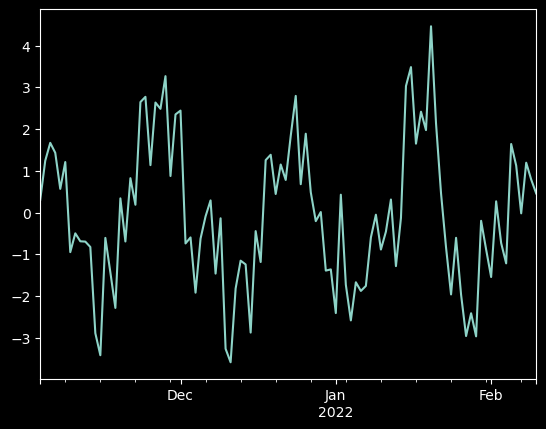

Seasonality Test for 25th lag: True
Seasonality identified for: 25


In [29]:
from src.transforms.stationary_utils import check_seasonality

y_seasonal.plot()
plt.show()
seasonality_res = check_seasonality(y_seasonal, max_lag=30, seasonal_period=25, confidence=0.05)
print(f"Seasonality Test for 25th lag: {seasonality_res.seasonal}")
seasonality_id_res = check_seasonality(y_seasonal, max_lag=60, confidence=0.05)
print(f"Seasonality identified for: {seasonality_res.seasonal_periods}")

## De-seasonalizing

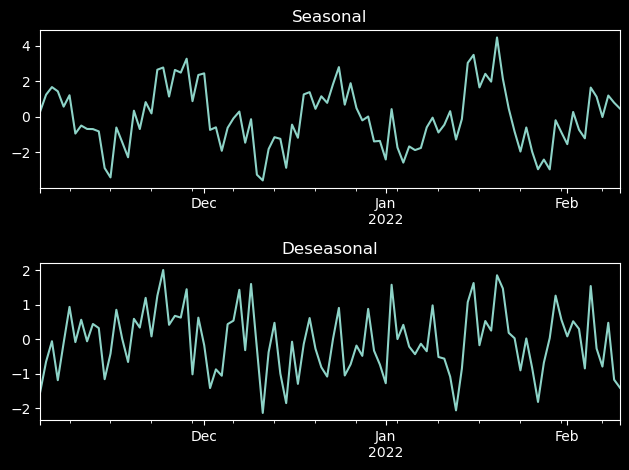

Seasonality at 25: False


In [30]:
from src.transforms.target_transformations import DeseasonalizingTransformer

deseasonalizing_transformer = DeseasonalizingTransformer(seasonality_extraction="period_averages",seasonal_period=25)
y_deseasonalized = deseasonalizing_transformer.fit_transform(y_seasonal, freq="1D")
fig, axs = plt.subplots(2)
y_seasonal.plot(title="Seasonal",ax=axs[0])
y_deseasonalized.plot(title="Deseasonal",ax=axs[1])
plt.tight_layout()
plt.show()
seasonality_res = check_seasonality(y_deseasonalized, seasonal_period=25, max_lag=26, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"Seasonality at {seasonality_res.seasonal_periods}: {seasonality_res.seasonal}")

# Heteroscedasticity

## Detecting Heteroscedasticity

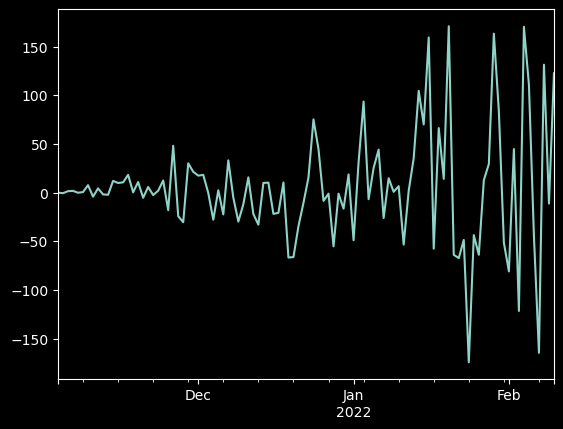

White Test for Heteroscedasticity: True with a p-value of 2.8244911172875216e-08


In [31]:
from src.transforms.stationary_utils import check_heteroscedastisticity

y_hetero.plot()
plt.show()
hetero_res = check_heteroscedastisticity(y_hetero, confidence=0.05)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

Now let's see what happens when seasonality exists

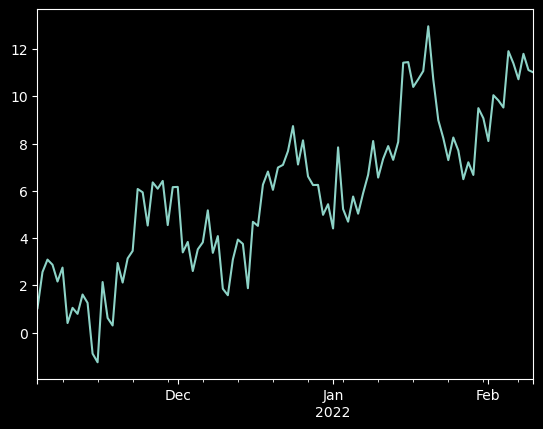

White Test for Heteroscedasticity: True with a p-value of 2.8244911172875216e-08


In [32]:
y_new = y_trend + y_seasonal
y_new.plot()
plt.show()
hetero_res = check_heteroscedastisticity(y_hetero, confidence=0.05)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

It came out positive, but we know that is false positive. The time series is pure trend + seasonality. This is because of the way heteroscedasticity is tested and it only consideres a trend internally. So it is advised to deseasonalize the data before applying the heteroscedasticity test.

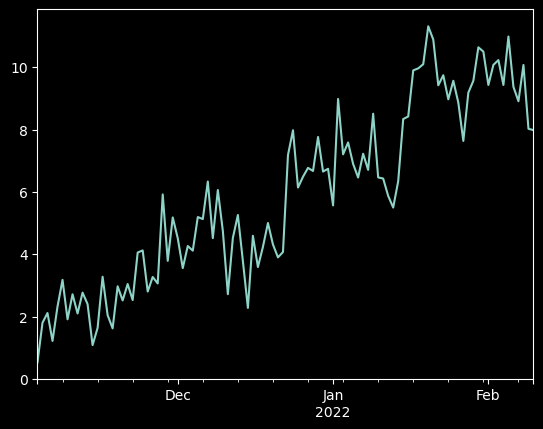

White Test for Heteroscedasticity: False with a p-value of 0.050405248699080335


In [33]:
y_new = y_trend + y_seasonal
deseasonalizing_transformer = DeseasonalizingTransformer(seasonality_extraction="period_averages",seasonal_period=25)
y_deseasonalized = deseasonalizing_transformer.fit_transform(y_new, freq="1D")
y_deseasonalized.plot()
plt.show()
hetero_res = check_heteroscedastisticity(y_deseasonalized, confidence=0.05)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

## Log Transforms

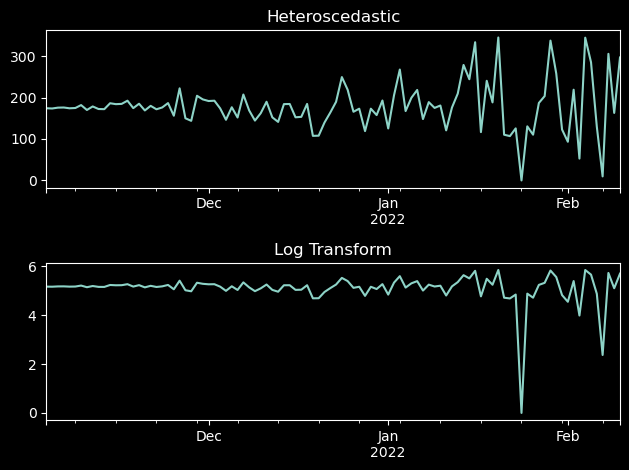

White Test for Heteroscedasticity: False with a p-value of 0.10395122689084516


In [34]:
from src.transforms.target_transformations import LogTransformer
#shifting the series into positive domain
_y_hetero = y_hetero-y_hetero.min()
log_transformer = LogTransformer(add_one=True)
y_log = log_transformer.fit_transform(_y_hetero)
fig, axs = plt.subplots(2)
_y_hetero.plot(title="Heteroscedastic",ax=axs[0])
y_log.plot(title="Log Transform",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_log, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

## Box-Cox Transforms

### Optimizing for $\lambda$ with Guerrero's method

Optimal Lambda: -0.9999965176267451


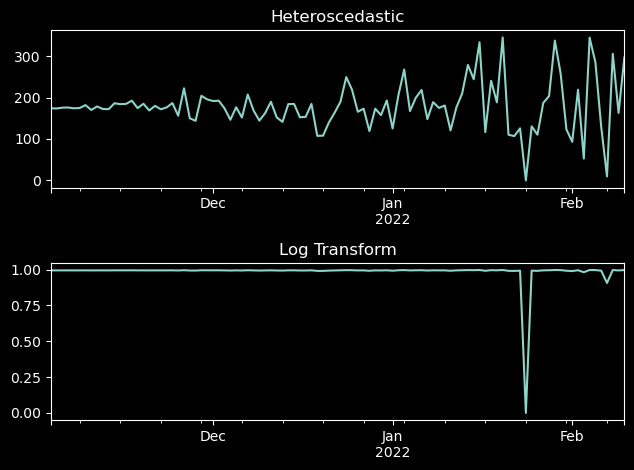

White Test for Heteroscedasticity: False with a p-value of 0.48218454776663144


In [35]:
from src.transforms.target_transformations import BoxCoxTransformer
#shifting the series into positive domain
_y_hetero = y_hetero-y_hetero.min()
#Arbritarily divided the data into sub-series of length 25
boxcox_transformer = BoxCoxTransformer(seasonal_period=25, add_one=True, optimization="guerrero")
y_boxcox = boxcox_transformer.fit_transform(_y_hetero)
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
_y_hetero.plot(title="Heteroscedastic",ax=axs[0])
y_boxcox.plot(title="Log Transform",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

### Optimizing for $\lambda$ with Loglikelihood

Optimal Lambda: 0.9262204252371791


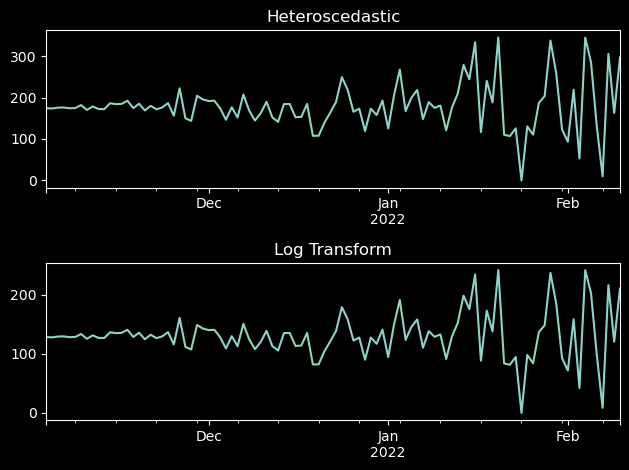

White Test for Heteroscedasticity: True with a p-value of 5.239208235547994e-08


In [36]:
#shifting the series into positive domain
_y_hetero = y_hetero-y_hetero.min()
boxcox_transformer = BoxCoxTransformer(add_one=True, optimization="loglikelihood")
y_boxcox = boxcox_transformer.fit_transform(_y_hetero)
print(f"Optimal Lambda: {boxcox_transformer.boxcox_lambda}")
fig, axs = plt.subplots(2)
_y_hetero.plot(title="Heteroscedastic",ax=axs[0])
y_boxcox.plot(title="Log Transform",ax=axs[1])
plt.tight_layout()
plt.show()
hetero_res = check_heteroscedastisticity(y_boxcox, confidence=0.05)
# mann_kendall_res = check_trend(y_diff, confidence=0.05, mann_kendall=True)
print(f"White Test for Heteroscedasticity: {hetero_res.heteroscedastic} with a p-value of {hetero_res.lm_p_value}")

# AutoStationary Transformer

<Axes: >

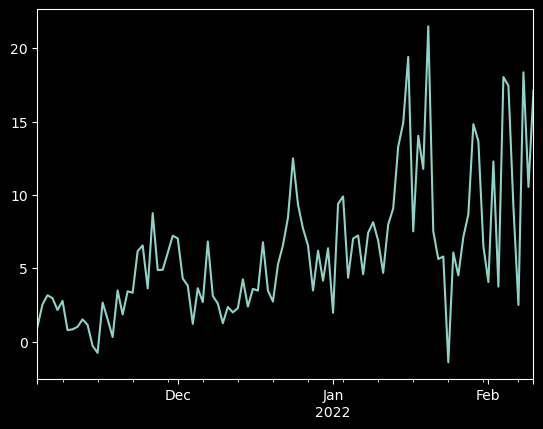

In [37]:
y_final = y_trend+y_seasonal+0.05*y_hetero
y_final.plot()

Transformations applied: ['DetrendingTransformer', 'DeseasonalizingTransformer', 'AddMTransformer', 'BoxCoxTransformer']


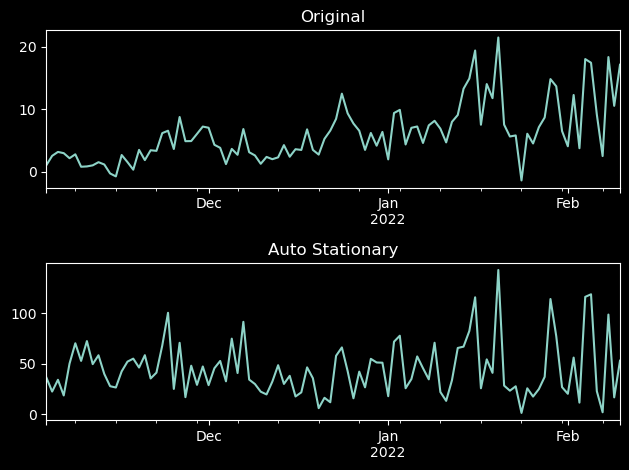

Unit Root: True with a p-value of 0.0009940530355200773
Inverse == Original @ precision of 2 decimal points: True


In [38]:
from src.transforms.target_transformations import AutoStationaryTransformer
auto_stationary = AutoStationaryTransformer(seasonal_period=25)
y_stat = auto_stationary.fit_transform(y_final)
print(f"Transformations applied: {[p.__class__.__name__ for p in auto_stationary._pipeline]}")
fig, axs = plt.subplots(2)
y_final.plot(title="Original",ax=axs[0])
y_stat.plot(title="Auto Stationary",ax=axs[1])
plt.tight_layout()
plt.show()
unit_root = check_unit_root(y_stat, confidence=0.05)
print(f"Unit Root: {unit_root.stationary} with a p-value of {unit_root.results[1]}")
y_inv = auto_stationary.inverse_transform(y_stat)
print(f"Inverse == Original @ precision of 2 decimal points: {np.all(y_inv.round(2)==y_final.round(2))}")

## Reading the preprocessed and feature engineered files

In [39]:
#Readin the missing value imputed and train test split data
try:
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    display(train_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2012-01-01 00:00:00,MAC000061,0.114,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2012-01-01 00:30:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
2,2012-01-01 01:00:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
3,2012-01-01 01:30:00,MAC000061,0.098,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
4,2012-01-01 02:00:00,MAC000061,0.060,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0


In [40]:
from src.transforms.target_transformations import AutoStationaryTransformer

In [41]:
#Takes a while. Snack Break!
transformer_pipelines = {}
for _id in tqdm(train_df["LCLid"].unique()):
    #Initialize the AutoStationaryTransformer with a seasonality period of 48*7
    auto_stationary = AutoStationaryTransformer(seasonal_period=48*7)
    #Creating the timeseries with datetime index
    y = train_df.loc[train_df["LCLid"]==_id, ["energy_consumption","timestamp"]].set_index("timestamp")
    #Fitting and trainsforming the train
    y_stat = auto_stationary.fit_transform(y, freq="30min")
    # Setting the transformerd series back to the dataframe
    train_df.loc[train_df["LCLid"]==_id, "energy_consumption"] = y_stat.values
    #Saving the pipeline
    transformer_pipelines[_id] = auto_stationary

  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\tacke\AppData\Local\Temp\ipykernel_12948\1570381919.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55546516 0.56021721 0.56302284 ... 0.56257263 0.5756974  0.56913136]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.



## Saving the transformed file as well as the transformer pipelines

In [42]:
train_df = train_df.loc[:,["LCLid","timestamp","energy_consumption"]].set_index(["LCLid","timestamp"])
train_df.rename(columns={"energy_consumption":"energy_consumption_auto_stat"}, inplace=True)


In [43]:
train_df.head()

energy_consumption_auto_stat
LCLid     timestamp                                        
MAC000061 2012-01-01 00:00:00                      0.555465
          2012-01-01 00:30:00                      0.560217
          2012-01-01 01:00:00                      0.563023
          2012-01-01 01:30:00                      0.560639
          2012-01-01 02:00:00                      0.553762

In [44]:
train_df.to_parquet(preprocessed/"selected_blocks_train_auto_stat_target.parquet")
joblib.dump(transformer_pipelines, preprocessed/"auto_transformer_pipelines_train.pkl")

['data\\london_smart_meters\\preprocessed\\auto_transformer_pipelines_train.pkl']